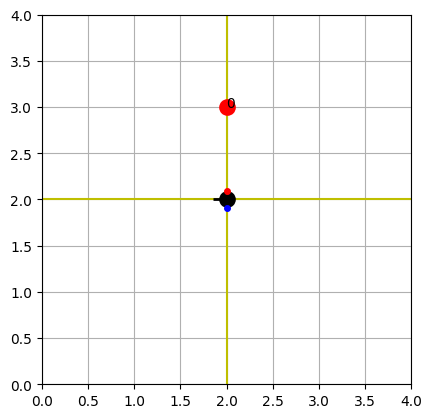

In [267]:
import numpy as np
from IPython.display import Audio
import scipy.signal as sig
import soundfile as sf
import matplotlib.pyplot as plt
import mat73
import os
import masp as srs
# import my modules (helpers.py where I stored all the functions):
import helpers as hlp
import importlib
importlib.reload(hlp)
# --------------- DESIGN SCENE ----------------
room = np.array([4., 4., 3.]) # Room dimensions
rt60 = np.array([.2])
head_pos= np.array([room[0]/2, room[1]/2, 1.6]) # Listener coordinates
sources_pos= hlp.place_on_circle(head_pos,1,0) # Sources coordinates 
head_orient = np.array([-90, 0]) # Head rotation in degrees
ears_pos=hlp.head_2_ku_ears(head_pos,head_orient)

# --------------- PLOT SCENE ----------------
hlp.plot_scene(room,head_pos,head_orient,ears_pos,sources_pos,perspective="xy")

In [268]:
# --------------- COMPUTE ECHOGRAMS ----------------

# some constants:
mic_specs = np.array([  [1, 0, 0, 1], [1, 0, 0, 1] ] ) #two omni mics facing to the front
fs = 16000 #sampling rate
maxlim = 2 # maximum reflection time in seconds. Stop simulating if it goes beyond that time.
ambi_order = 10 # ambisonics order
rims_d = 0.0 # displacement for Randomized Image Source method. Default is 0.

# Compute absorption coefficients for desired rt60 and room dimensions
abs_walls,rt60_true = srs.find_abs_coeffs_from_rt(room, rt60)
# Small correction for sound absorption coefficients:
if sum(rt60_true-rt60>0.05*rt60_true)>0 :
    abs_walls,rt60_true = srs.find_abs_coeffs_from_rt(room, rt60_true + abs(rt60-rt60_true))
# Generally, we simulate up to RT60:
limits = np.minimum(rt60, maxlim)

# microphones corresponding to ear positions (input for binaural decoder)
ear_mics = np.array(ears_pos) # input for binaural decoder)
head_mic =np.array([head_pos])
src = np.array(sources_pos)

# Compute the echograms, which means how many reflections, at what time and from which coordinates:
abs_echogram_ears = srs.compute_echograms_sh(room, src, ear_mics, abs_walls, limits, ambi_order, rims_d, head_orient);print(f'{abs_echogram_ears.shape=}')

abs_echogram_ears.shape=(1, 2, 1)


In [269]:
# --------------- RENDER ECHOGRAMS ----------------
band_centerfreqs=np.array([1000])
ears_rirs = srs.render_rirs_sh(abs_echogram_ears, band_centerfreqs, fs); print(f'{ears_rirs.shape=}')

ears_rirs.shape=(3200, 121, 2, 1)


In [286]:
# ----------- CREATE SOURCE SIGNAL IN SPHERICAL HARMONICS -------------
# mono source:
source_sig, fs2 = sf.read('test1.wav')
source_sig=sig.resample_poly(source_sig[:,0], 16000, fs2)
source_sig= np.array([source_sig[1:32000].T])

# for a mic position in the center of the head 
sh_head_center=hlp.generate_sig_in_SH(source_sig,np.squeeze(head_rirs).T); print(f'{sh_head_center.shape=}')
# for a mic position at the left ear
sh_left=hlp.generate_sig_in_SH(source_sig,np.squeeze(ears_rirs[:,:,0, :].T)); print(f'{sh_left.shape=}')
# for a mic position at the right ear
sh_right=hlp.generate_sig_in_SH(source_sig,np.squeeze(ears_rirs[:,:,1, :].T)); print(f'{sh_right.shape=}')


sh_head_center.shape=(121, 35198)
sh_left.shape=(121, 35198)
sh_right.shape=(121, 35198)


In [287]:
# -------- LOAD DECODERS -----------
# Bimag decoding method (2 mics sh -> binaural), our IRs:
dec_ku100_ha = mat73.loadmat('ku100_ha.mat')['hnm'] # (2048, 121, 2)
dec_ku100_inear = mat73.loadmat('ku100_inear.mat')['hnm'] # (2048, 121, 2)
dec_ku100_ha_test = mat73.loadmat('ku100_ha_test.mat')['hnm'] # (2048, 121, 2)
dec_ku100_inear_test = mat73.loadmat('ku100_inear_test.mat')['hnm'] # (2048, 121, 2)
decoders = mat73.loadmat('decoders_v3.mat')
dec_ku100_ha_test_v3 = decoders['decoder_HA'] # (2048, 121, 2)
dec_ku100_inear_test_v3 = decoders['decoder_KU100'] # (2048, 121, 2)

# Bimag decoding method (2 mics sh -> binaural), Oldenburg IRs:
dec_oldenBimag_inear =  mat73.loadmat('BKwoHA_inear.mat')['hnm'] #  (8192, 121, 2)
dec_oldenBimag_HAmic =  mat73.loadmat('BKwHA_HAmic.mat')['hnm']  # (8192, 121, 2)

# magls decoding method (1 mic sh -> binaural), Oldenburg IRs:
dec_oldenMagLS_inear =  np.load('spaudiopy_magls_oldenburg.npy').T #  (1600, 121, 2)

# magls decoding method (1 mic sh -> binaural), our IRs:
dec_ourDataMagLS_ha =  np.load('spaudiopy_magls_ourRIC.npy').T # (42, 121, 2)


In [350]:
# ----------- DECODE TO BINAURAL AND COMPARE -------------

# our decoding method: 
sig_Bimag=hlp.sh_2mics_to_binaural(sh_left,sh_right,dec_ku100_ha_test_v3)
# magls decoding method: 
sig_MagLS=hlp.sh_2mics_to_binaural(sh_left,sh_right,dec_ourDataMagLS_ha)

In [351]:
Audio(sig_MagLS,rate=fs)

In [352]:
Audio(sig_Bimag,rate=fs)